In [1]:
import fiona
import osmnx as ox
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
import rasterio
from rasterio.mask import mask
from matplotlib.lines import Line2D

In [2]:
# check layers 
print(fiona.listlayers("gadm41_USA.gpkg"))

# import data
df1 = gpd.read_file("gadm41_USA.gpkg", layer = "ADM_ADM_2")

# creating subset for georgia & south carolina
df2 = df1[(df1["NAME_1"] == "Georgia") | (df1["NAME_1"] == "South Carolina")]

['ADM_ADM_0', 'ADM_ADM_1', 'ADM_ADM_2']


In [3]:
# Create a node list for each county with their name and geo data included as node attributes
node_list = []
for idx, row in df2.iterrows():
    node = (
                row['NAME_1'] + '_' + row['NAME_2'],
                {
                    'state': row['NAME_1'],                    
                    'county': row['NAME_2'],
                    'geometry': row['geometry']
                }
            )
    node_list.append(node)


In [4]:
# Create a graph
Counties_Graph = nx.Graph()

# Add nodes to the graph
Counties_Graph.add_nodes_from(node_list)

# BEGIN: Add edges to the graph based on neighboring counties
for i, node1 in enumerate(node_list):
    for j, node2 in enumerate(node_list):
        if i < j and node1[1]['geometry'].touches(node2[1]['geometry']):
            Counties_Graph.add_edge(node1[0], node2[0])


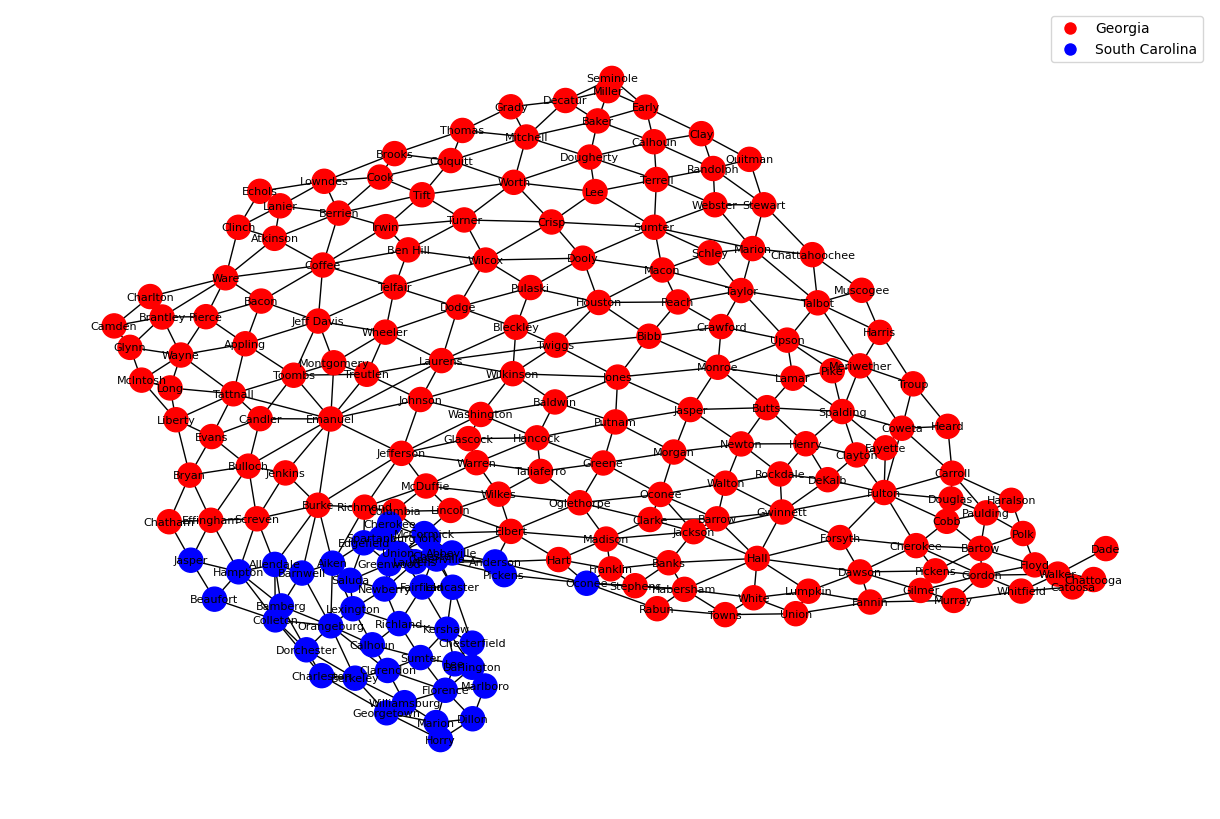

In [5]:
# Define node colors based on the state
plt.figure(figsize=(12, 8))  # Increase the width of the plot
node_colors = ['red' if data['state'] == 'Georgia' else 'blue' for _, data in Counties_Graph.nodes(data=True)]

# Create custom legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Georgia', markersize=10, markerfacecolor='red'),
                   Line2D([0], [0], marker='o', color='w', label='South Carolina', markersize=10, markerfacecolor='blue')]

# Draw the graph with county names as labels and colored nodes
pos = nx.spring_layout(Counties_Graph, seed=43)
nx.draw(Counties_Graph, pos, with_labels=True, labels={node: data['county'] for node, data in Counties_Graph.nodes(data=True)}, node_color=node_colors, font_size=8)
plt.legend(handles=legend_elements, loc='best')
plt.show()
node_colors = ['red' if data['state'] == 'Georgia' else 'blue' for _, data in Counties_Graph.nodes(data=True)]


In [6]:
Counties_Graph.nodes('geometry')

NodeDataView({'Georgia_Appling': <MULTIPOLYGON (((-82.227 31.531, -82.228 31.532, -82.228 31.533, -82.229 31....>, 'Georgia_Atkinson': <MULTIPOLYGON (((-83.047 31.184, -83.047 31.185, -83.047 31.186, -83.047 31....>, 'Georgia_Bacon': <MULTIPOLYGON (((-82.521 31.711, -82.5 31.711, -82.496 31.711, -82.496 31.71...>, 'Georgia_Baker': <MULTIPOLYGON (((-84.635 31.434, -84.61 31.433, -84.597 31.433, -84.586 31.4...>, 'Georgia_Baldwin': <MULTIPOLYGON (((-83.357 32.926, -83.361 32.936, -83.366 32.952, -83.367 32....>, 'Georgia_Banks': <MULTIPOLYGON (((-83.398 34.46, -83.389 34.441, -83.388 34.44, -83.388 34.43...>, 'Georgia_Barrow': <MULTIPOLYGON (((-83.799 33.93, -83.8 33.931, -83.8 33.932, -83.801 33.932, ...>, 'Georgia_Bartow': <MULTIPOLYGON (((-84.654 34.412, -84.653 34.402, -84.653 34.381, -84.653 34....>, 'Georgia_Ben Hill': <MULTIPOLYGON (((-82.996 31.781, -82.996 31.775, -82.997 31.762, -82.997 31....>, 'Georgia_Berrien': <MULTIPOLYGON (((-83.14 31.421, -83.139 31.418, -83.138 31.416, 

In [7]:
from shapely.geometry import mapping

# Convert geometry to WKT strings
for node, data in Counties_Graph.nodes(data=True):
    if 'geometry' in data:
        data['geometry'] = data['geometry'].wkt  # Convert to WKT string

# Save the graph
nx.write_gml(Counties_Graph, "county_graph.gml")
